### Prereq: install any necessary libraries you don't already have ↓

In [10]:
#pip install -r requirements.txt

In [11]:
#print out which python is being used
import sys, os
print(sys.executable)

c:\Program Files\Python311\python.exe


In [12]:
#import libraries

import numpy as np
import pandas as pd
#data processing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
#hyperparameter tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
#evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix,make_scorer, fbeta_score
#visualization
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# Load data

In [13]:
#load in the data from the dataset

#get name of the zip file
file_path = 'kddcup.data.gz'

#define the column names based on the kddcup.names file
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_hot_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

#read the dataset into a pandas dataframe
df = pd.read_csv(file_path, header=None, names=columns, compression='gzip')

#create dictionaries for final evaluation
accuracy_scores = {}
precision_scores = {}
recall_scores = {}

### Basic EDA

In [14]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [15]:
df.tail(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.
4898430,0,tcp,http,SF,219,1098,0,0,0,0,...,255,1.0,0.0,0.14,0.05,0.0,0.01,0.0,0.0,normal.


In [7]:
df.sample(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
822535,0,tcp,http,SF,224,788,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
3032136,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
3749200,0,tcp,private,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
793473,0,tcp,http,SF,155,19010,0,0,0,0,...,255,1.00,0.00,0.01,0.04,0.0,0.0,0.0,0.0,normal.
4688911,0,tcp,private,REJ,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,0.0,0.0,1.0,1.0,neptune.
725815,0,udp,domain_u,SF,36,0,0,0,0,0,...,208,1.00,0.00,1.00,0.01,0.0,0.0,0.0,0.0,normal.
3921308,0,tcp,private,S0,0,0,0,0,0,0,...,14,0.05,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
439138,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
1629576,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
4433230,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


In [16]:
#count the number of attacks in the dataset
df["label"].value_counts()

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

# Data processing

In [17]:
#data processing 1: drop nulls and NaNs
# remove rows with missing values or NaNs
df = df.dropna().reset_index(drop=True)

print(f"Number of rows after dropping missing values: {df.shape[0]} ")

Number of rows after dropping missing values: 4898431 


In [18]:
#data processing 2: data deduplication

#print a sample of the duplicate rows
duplicate_rows = df.duplicated()
print(f"Number of duplicate records: {duplicate_rows.sum()}")

#drop the duplicates
df = df.drop_duplicates().reset_index(drop=True)

#print number of records after removing duplicates
print(f"Number of rows after deduplication: {df.shape[0]}")

#print a small example of some duplicate records
print("Sample of duplicate records:")
df.loc[duplicate_rows].sample(3)

Number of duplicate records: 3823439
Number of rows after deduplication: 1074992
Sample of duplicate records:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1008969,4725,udp,other,SF,147,105,0,0,0,0,...,2,0.01,0.64,0.93,0.00,0.0,0.0,0.0,0.0,normal.
961255,0,tcp,http,SF,208,3410,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal.
102292,0,tcp,http,SF,246,1408,0,0,0,0,...,255,1.00,0.00,0.02,0.02,0.0,0.0,0.0,0.0,normal.


In [19]:
#separate the features and label into different dataframes

#get all columns except the label
X = df.drop(columns=["label"])

#get only the label column
y = df["label"]

In [20]:
X.sample(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
148732,2,tcp,smtp,SF,1505,405,0,0,0,0,...,48,237,0.96,0.04,0.02,0.01,0.0,0.00,0.0,0.0
737127,0,tcp,ftp_data,SF,59,0,0,0,0,0,...,193,40,0.21,0.02,0.21,0.00,0.0,0.00,0.0,0.0
657230,0,tcp,http,SF,253,2771,0,0,0,0,...,26,255,1.00,0.00,0.04,0.01,0.0,0.01,0.0,0.0


In [26]:
y.sample(3)

803730    neptune.
29700      normal.
739014     normal.
Name: label, dtype: object

In [27]:
#data processing 3.1 data encoding, labels

#get a sample of target values
#use the index so we can get the same data points after encoding
sample_idxs = y.sample(10).index

#sample the labels before encoding
print("Before label encoding:")
print(y.loc[sample_idxs])

#encode the label such that normal = 0, any attack = 1
y = (y != "normal.").astype(int)

#sample the labels after encoding
print("After label encoding:")
y.loc[sample_idxs]



Before label encoding:
62026      normal.
908613     normal.
320459     normal.
1030943    normal.
603686     normal.
312799     normal.
8959       normal.
574705     normal.
667493     normal.
319882     normal.
Name: label, dtype: object
After label encoding:


62026      0
908613     0
320459     0
1030943    0
603686     0
312799     0
8959       0
574705     0
667493     0
319882     0
Name: label, dtype: int64

In [28]:
#count number of attacks after label encoding
y.value_counts()

label
0    812814
1    262178
Name: count, dtype: int64

In [29]:
# data processing 3.2: data encoding, features

#define the columns that have categorical data
categorical_cols = ["protocol_type", "service", "flag"]

#remove the categorical and label columns
numeric_cols      = X.columns.difference(categorical_cols)

#use a pipeline to transform categorical data into one‑hot data
categorical_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])


In [30]:
#data processing 4: normalization

#take values in each column and normalize so that they are proportional but in the range (0, 1)
#use a pipeline to standardize column values
numeric_pipe = Pipeline([
    ("scaler", StandardScaler())
])

In [31]:
#create a column transformers using the two pipelines
preprocess = ColumnTransformer([
    ("encode", categorical_pipe, categorical_cols),
    ("standardize", numeric_pipe, numeric_cols)
])

In [32]:
#split the dataset into training and testing data
#stratify since the dataset is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [33]:
#transform the feature datasets to get the encoding/scaling

#fit on training dataset
preprocess.fit(X_train)

#transform both training and testing datasets
X_train_transformed = preprocess.transform(X_train)
X_test_transformed = preprocess.transform(X_test)

#get the column names
new_feature_names = preprocess.get_feature_names_out()

#turn back into dataframes
X_train = pd.DataFrame(X_train_transformed, columns=new_feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_transformed, columns=new_feature_names, index=X_test.index)

In [34]:
#preview new feature names
X_train.columns.difference(columns)

Index(['encode__flag_OTH', 'encode__flag_REJ', 'encode__flag_RSTO',
       'encode__flag_RSTOS0', 'encode__flag_RSTR', 'encode__flag_S0',
       'encode__flag_S1', 'encode__flag_S2', 'encode__flag_S3',
       'encode__flag_SF',
       ...
       'standardize__same_srv_rate', 'standardize__serror_rate',
       'standardize__src_bytes', 'standardize__srv_count',
       'standardize__srv_diff_host_rate', 'standardize__srv_rerror_rate',
       'standardize__srv_serror_rate', 'standardize__su_attempted',
       'standardize__urgent', 'standardize__wrong_fragment'],
      dtype='object', length=122)

In [35]:
#print information about dataset after preprocessing

print("Training Set:")
print(f"Number of rows after data processing: {X_train.shape[0]}")
print(f"Number of features before encoding: {X_train.shape[1]}", end='\n\n')


print("Testing Set:")
print(f"Number of rows after data processing: {X_test.shape[0]}")
print(f"Number of features before encoding: {X_test.shape[1]}")

Training Set:
Number of rows after data processing: 859993
Number of features before encoding: 122

Testing Set:
Number of rows after data processing: 214999
Number of features before encoding: 122


# Supervised Learners

### Model 1: Decision Tree - Carlos

In [38]:
#hyperparameter tuning

#initialize the model
estimator = DecisionTreeClassifier(class_weight="balanced", random_state=42)

#define the set of parameters to tune
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 5, 10, 15, 20],
    "min_samples_leaf": [250, 500, 1000, 2500, 5000]
}

#track accuracy, precision, and recall
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score)
}

#define the cross-validator
#use stratified folds to preserve the proportion of attacks to normal traffic
cv = StratifiedKFold(shuffle=True, random_state=42)

#prefer models with higher recall in the search
search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring=scoring, n_jobs=-1, refit="Recall", cv=cv, random_state=42)

#fit the model to the training data
search.fit(X_train, y_train)

#print out the optimal hyperparameters
print("Best hyper-parameters:", search.best_params_)


Best hyper-parameters: {'min_samples_leaf': 250, 'max_depth': 20, 'criterion': 'entropy'}


In [39]:
#make predictions using the optimal model
best = search.best_params_

#initialize a model using tuned hyperparameters
model = DecisionTreeClassifier(criterion=best["criterion"], max_depth=best["max_depth"], min_samples_leaf=best["min_samples_leaf"], class_weight='balanced', random_state=42)

#fit the model to the training data
model.fit(X_train, y_train)

#make predictions using the trained model
dt_predictions = model.predict(X_test)

#also make predictions using the training data to test for overfitting
dt_training_predictions = model.predict(X_train)

In [40]:
#evaluate model's performance and store results for final evaluation

#accuracy
dt_train_accuracy = accuracy_score(y_train, dt_training_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy (Training): {dt_train_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}", end='\n\n')

#precision
dt_train_precision = precision_score(y_train, dt_training_predictions)
dt_precision = precision_score(y_test, dt_predictions)
print(f"Decision Tree Precision (Training): {dt_train_precision}")
print(f"Decision Tree Precision: {dt_precision}", end='\n\n')

#recall
dt_train_recall = recall_score(y_train, dt_training_predictions)
dt_recall = recall_score(y_test, dt_predictions)
print(f"Decision Tree Recall (Training): {dt_train_recall}")
print(f"Decision Tree Recall: {dt_recall}", end='\n\n')

#store scores for later comparison
accuracy_scores['DecisionTree'] = dt_accuracy
precision_scores['DecisionTree'] = dt_precision
recall_scores['DecisionTree'] = dt_recall


Decision Tree Accuracy (Training): 0.9985220809936826
Decision Tree Accuracy: 0.9985023186154354

Decision Tree Precision (Training): 0.9964138929501802
Decision Tree Precision: 0.9965697297709342

Decision Tree Recall (Training): 0.9975302991294066
Decision Tree Recall: 0.9972919368372873



In [ ]:
#confusion matrix
print(confusion_matrix(y_test, dt_predictions))


[[162383    180]
 [   142  52294]]


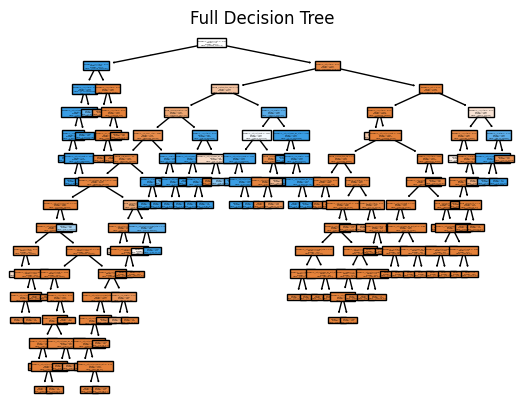

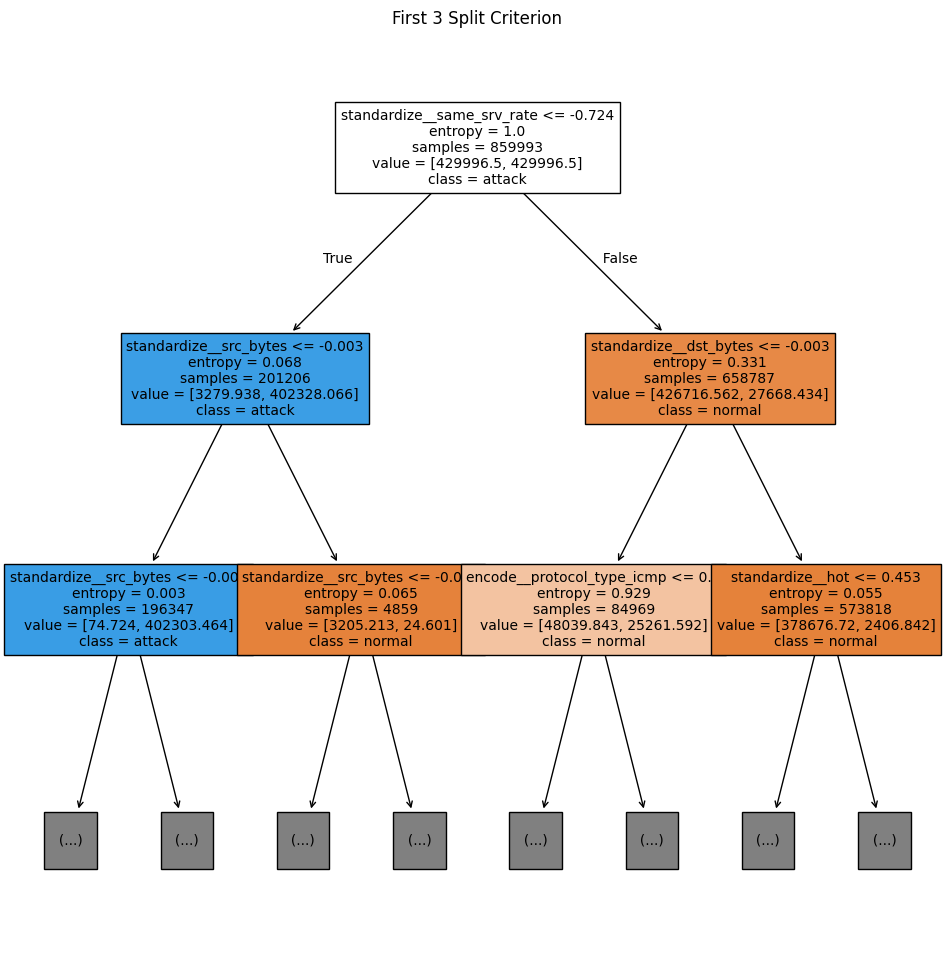

In [ ]:
#plot the decision tree

#very zoomed out
plot_tree(model, feature_names=new_feature_names, class_names=["normal", "attack"], filled=True)
plt.title("Full Decision Tree")
plt.show()

#zoomed in to first few splits
#increase size of plot
plt.figure(figsize=(12, 12)) 
plot_tree(model, feature_names=new_feature_names, class_names=["normal", "attack"], filled=True, max_depth=2, fontsize=10)

plt.title("First 3 Split Criterion")
plt.show()

### Model 2: Random Forest - Juan

In [41]:
#get smaller dataset for tuning

#df already has duplicates removed
#get the tuning samples
X_tune = X_train.sample(frac=0.2, random_state=42)

#get the same datapoints using index
y_tune = y_train.loc[X_tune.index] 

In [44]:
#TRAINING RANDOM FOREST

#initialize rf model
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", random_state=42)

#define set of hyperparameters to tune
param_grid = {
    "n_estimators"     : [100, 200, 400],
    "max_depth"        : [None, 20, 40, 60],
    "min_samples_leaf" : [1, 2, 4],
    "max_features"     : ["sqrt", 0.1, 0.3]  # 0.3 = 30 % of features
}

#track accuracy, precision, and recall while tuning
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(accuracy_score),
    "Recall": make_scorer(recall_score)
}

#use a stratified cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#tune parameters
#use half as many iterations for performance
search = RandomizedSearchCV(
    estimator      = rf,
    param_distributions = param_grid,
    n_iter         = 5,
    scoring        = scoring,
    refit          = "Recall",
    cv             = cv,
    n_jobs         = -1,
    random_state   = 42
)

#fit to training data
search.fit(X_tune, y_tune)
print("Best hyper-parameters:", search.best_params_)

C:\Users\Acer Nitro 5\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyper-parameters: {'n_estimators': 400, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 40}


In [45]:
# Building RF with best parameters
best = search.best_params_

#initialize model with optimal parameters
rf_final = RandomForestClassifier(
    n_estimators     = best["n_estimators"],
    max_depth        = best["max_depth"],
    min_samples_leaf = best["min_samples_leaf"],
    max_features     = best["max_features"],
    n_jobs           = -1,
    class_weight     = "balanced",
    random_state     = 42,
)

#fit to training data
rf_final.fit(X_train, y_train)

#predict test data labels
y_pred = rf_final.predict(X_test)

#predict training labels to test for overfitting
y_train_pred = rf_final.predict(X_train)

In [46]:
##RANDOM FOREST EVALUATION 

#accuracy
rf_train_accuracy = accuracy_score(y_train, y_train_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy (Training): {rf_train_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}", end='\n\n')

#precision
rf_train_precision = precision_score(y_train, y_train_pred)
rf_precision = precision_score(y_test, y_pred)
print(f"Random Forest Precision (Training): {rf_train_precision}")
print(f"Random Forest Precision: {rf_precision}", end='\n\n')

#recall
rf_train_recall = recall_score(y_train, y_train_pred)
rf_recall = recall_score(y_test, y_pred)
print(f"Random Forest Recall (Training): {rf_recall}")
print(f"Random Forest Recall: {rf_recall}", end='\n\n')

#store scores for later comparison
accuracy_scores['RandomForest'] = rf_accuracy
precision_scores['RandomForest'] = dt_precision
recall_scores['RandomForest'] = rf_recall

Random Forest Accuracy (Training): 0.9999732555962665
Random Forest Accuracy: 0.9998651156517007

Random Forest Precision (Training): 0.9999189522915047
Random Forest Precision: 0.9998092585881321

Random Forest Recall (Training): 0.9996376535204821
Random Forest Recall: 0.9996376535204821



In [47]:
#RANDOM FOREST CONFUSION MATRIX

metrics = {
    "F1":        f1_score(y_test, y_pred),
    "F2":        fbeta_score(y_test, y_pred, beta=2),
    "FNR":       1 - recall_score(y_test, y_pred),
}

print("F1:", metrics["F1"])
print("F2:", metrics["F2"])
print("FNR:", metrics["FNR"])
print(confusion_matrix(y_test, y_pred))

F1: 0.9997234486901958
F2: 0.9996719698212235
FNR: 0.00036234647951793875
[[162553     10]
 [    19  52417]]


# Unsupervised Learners

### Model 3: K-Means Clustering - Antonio

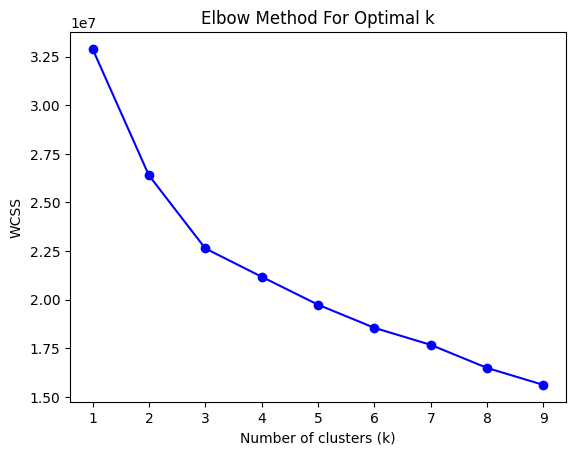

In [16]:
#use the elbow method to determine optimal number of clusters

#initialize WCSS (within-cluster sum of squares) used to determine optimal # of clusters
wcss = []

#test different values of k (number of clusters) 1-9
K = range(1, 10)

#for each k, fit the model and calculate WCSS 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
# hyperparameter tuning
import numpy as np
from sklearn.metrics import silhouette_score, f1_score
from sklearn.cluster import KMeans

#Subsample the dataset to speed up tuning (otherwise takes too long)
sample_size = 10000
rng = np.random.RandomState(42)
indices = rng.choice(X_train.shape[0], size=sample_size, replace=False)

X_sampled = X_train.iloc[indices]
y_sampled = y.iloc[indices].values  # subsample labels too

#Hyperparameter tuning: determine best number of clusters (k)
k_range = [2, 3, 4]
best_k = None
best_silhouette = -1

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_sampled)
    silhouette = silhouette_score(X_sampled, kmeans.labels_)
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_k = k

print(f"Best number of clusters (k): {best_k} with silhouette score: {best_silhouette:.4f}")

#Fit KMeans with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(X_sampled)

#Compute distances to nearest cluster center
distances = kmeans.transform(X_sampled)
min_distances = np.min(distances, axis=1)

#Tune anomaly threshold using F1 score
best_threshold = None
best_f1 = 0

#Iterate over percentiles to find best threshold
for p in range(80, 100):  
    threshold = np.percentile(min_distances, p)
    preds = (min_distances >= threshold).astype(int)
    score = f1_score(y_sampled, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = threshold

print(f"Best anomaly threshold: {best_threshold:.4f} with F1 score: {best_f1:.4f}")


Best number of clusters (k): 2 with silhouette score: 0.9904
Best anomaly threshold: 5.9021 with F1 score: 0.1951


In [49]:
#train model using optimal hyperparameters
kmeans = KMeans(n_clusters=3, random_state=42)

#fit the training data
kmeans.fit(X_train)

#predict using distances to centroids
distances = kmeans.transform(X_train)
min_distances = np.min(distances, axis=1)

#Anomaly threshold – set based on percentile (#TODO tune this!)
threshold = np.percentile(min_distances, 90)
#Label by letting 0 = normal, 1 = attack
kmeans_preds = (min_distances >= threshold).astype(int) 


In [50]:
#evaluation

#accuracy
kmeans_accuracy = accuracy_score(y_train, kmeans_preds)
print(f"KMeans Accuracy: {kmeans_accuracy}")

#precision
kmeans_precision = precision_score(y_train, kmeans_preds)
print(f"KMeans Precision: {kmeans_precision}")

#recall
kmeans_recall = recall_score(y_train, kmeans_preds)
print(f"KMeans Recall: {kmeans_recall}", end='\n\n')

#store scores for later comparison
accuracy_scores['KMeans'] = kmeans_accuracy
precision_scores['KMeans'] = kmeans_precision
recall_scores['KMeans'] = kmeans_recall

#Evaluate the model
#Evaluate model using confusion matrix and classification report
print("Confusion Matrix:\n")
print(confusion_matrix(y_train, kmeans_preds))

print("Classification Report:\n")
print(classification_report(y_train, kmeans_preds))

KMeans Accuracy: 0.6913160921077265
KMeans Precision: 0.17602325581395348
KMeans Recall: 0.07217438567382785

Confusion Matrix:

[[579389  70862]
 [194604  15138]]
Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.89      0.81    650251
           1       0.18      0.07      0.10    209742

    accuracy                           0.69    859993
   macro avg       0.46      0.48      0.46    859993
weighted avg       0.61      0.69      0.64    859993



C:\Users\Acer Nitro 5\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


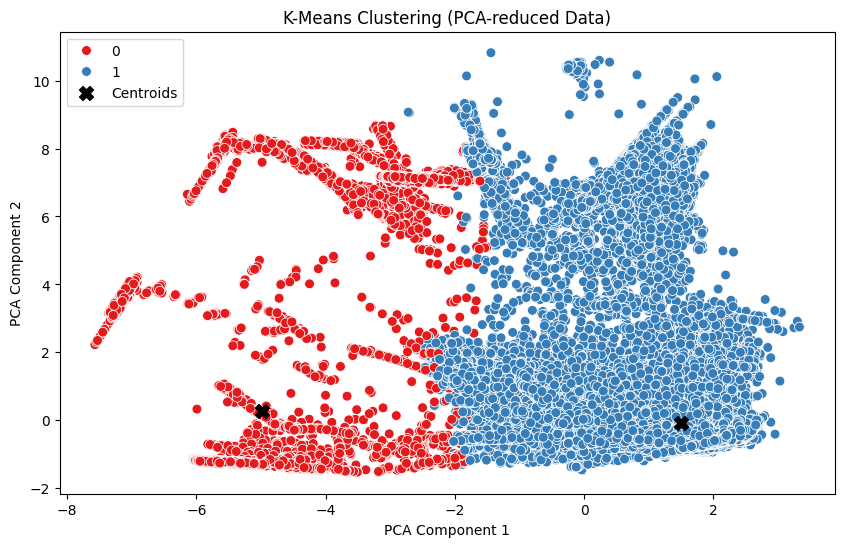

In [20]:
#visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train) 

#TODO fit kmeans with optimal k
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_train)

#create scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=50)

#plot 
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=100, c='black', marker='X', label='Centroids')

plt.title("K-Means Clustering (PCA-reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

### Model 4: Isolation Forest - Amilcar

In [51]:
import numpy as np
from sklearn.ensemble import IsolationForest

# Use subsample of the data
X_sampled = X_train.sample(frac=0.2, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

# model performance before hyperparameter tuning
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_sampled)

scores = model.decision_function(X_test) # scores usualy return a postive value for normal predictions
anomaly_scores = -scores  # flipped signs  to help with logic logic

threshold = np.percentile(anomaly_scores, 90) # 10 percent
y_pred = (anomaly_scores >= threshold).astype(int) # 0 is normal, 1 is attack

print("Model before hyperparameter tuning")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
                                            

Model before hyperparameter tuning
Accuracy: 0.745701142796013
Precision: 0.44795348837209303
Recall: 0.18367152338088336
F1 Score: 0.2605226141527808
Confusion Matrix:
 [[150694  11869]
 [ 42805   9631]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85    162563
           1       0.45      0.18      0.26     52436

    accuracy                           0.75    214999
   macro avg       0.61      0.56      0.55    214999
weighted avg       0.70      0.75      0.70    214999



In [52]:
#hyperparameter tuning 
# use f1 score to tune parameters
n_estimators_list = [100, 125, 150, 200]
max_samples_list = [64, 128, "auto", 512]
optimal_num_trees = None
optimal_max_sample = None
best_f1 = 0

for n_estimator in n_estimators_list:
    for max_sample in max_samples_list:
        model = IsolationForest(
            n_estimators = n_estimator,
            contamination = 'auto', 
            max_samples = max_sample, 
            random_state = 42)
        model.fit(X_sampled)
        
        # anomaly scores
        scores = model.decision_function(X_test)
        anomaly_scores = -scores
        
        # only 10% of outliers will be considered anamolies for this test
        threshold = np.percentile(anomaly_scores, 90)
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        f1 = f1_score(y_test, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            optimal_num_trees = n_estimator
            optimal_max_sample = max_sample
            
print("Optimal number of trees: ", optimal_num_trees, "Optimal max samples: ", optimal_max_sample)

Optimal number of trees:  200 Optimal max samples:  auto


In [53]:
#train model to find optimal threshold; could've been done earlier but trying to save run time
best_f1 = 0
optimal_threshold = None

model = IsolationForest(
    n_estimators=optimal_num_trees,
    max_samples=optimal_max_sample, 
    contamination='auto', 
    random_state=42)
model.fit(X_sampled)
 
scores = model.decision_function(X_test)
anomaly_scores = -scores

for p in range(80, 100): 
    threshold = np.percentile(anomaly_scores, p)
    y_pred = (anomaly_scores >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)

    if f1 > best_f1: # use f1 score to get best threshold value
        best_f1 = f1
        optimal_threshold = threshold
print("Optimal threshold", round(optimal_threshold, 4))

Optimal threshold -0.0722


In [54]:
#evaluation with optimal parameters

#train model with optimal parameters
model = IsolationForest(
    n_estimators = optimal_num_trees,
    max_samples = optimal_max_sample,
    contamination = 'auto',
    random_state = 42
)
model.fit(X_sampled)

# prediction with optimal parameters
scores = model.decision_function(X_test)
anomaly_scores = -scores
y_pred = (anomaly_scores >= optimal_threshold).astype(int)

# model evaluation with optimal parameters
if_accuracy = accuracy_score(y_test, y_pred)
if_precision = precision_score(y_test, y_pred)
if_recall = recall_score(y_test, y_pred)
print("Model after hyperparameter tuning:")
print("Isolation Forest accuracy:", if_accuracy)
print("Isolation Forest precision:", if_precision)
print("Isolation Forest recall:", if_recall)
print("Isolation Forest F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# storing values for later comparison
accuracy_scores['IsolationForest'] = if_accuracy
precision_scores['IsolationForest'] = if_precision
recall_scores['IsolationForest'] = if_recall

Model after hyperparameter tuning:
Isolation Forest accuracy: 0.6994962767268685
Isolation Forest precision: 0.35846511627906974
Isolation Forest recall: 0.2939583492257228
Isolation Forest F1 Score: 0.323022758707406
Confusion Matrix:
 [[134977  27586]
 [ 37022  15414]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81    162563
           1       0.36      0.29      0.32     52436

    accuracy                           0.70    214999
   macro avg       0.57      0.56      0.56    214999
weighted avg       0.68      0.70      0.69    214999



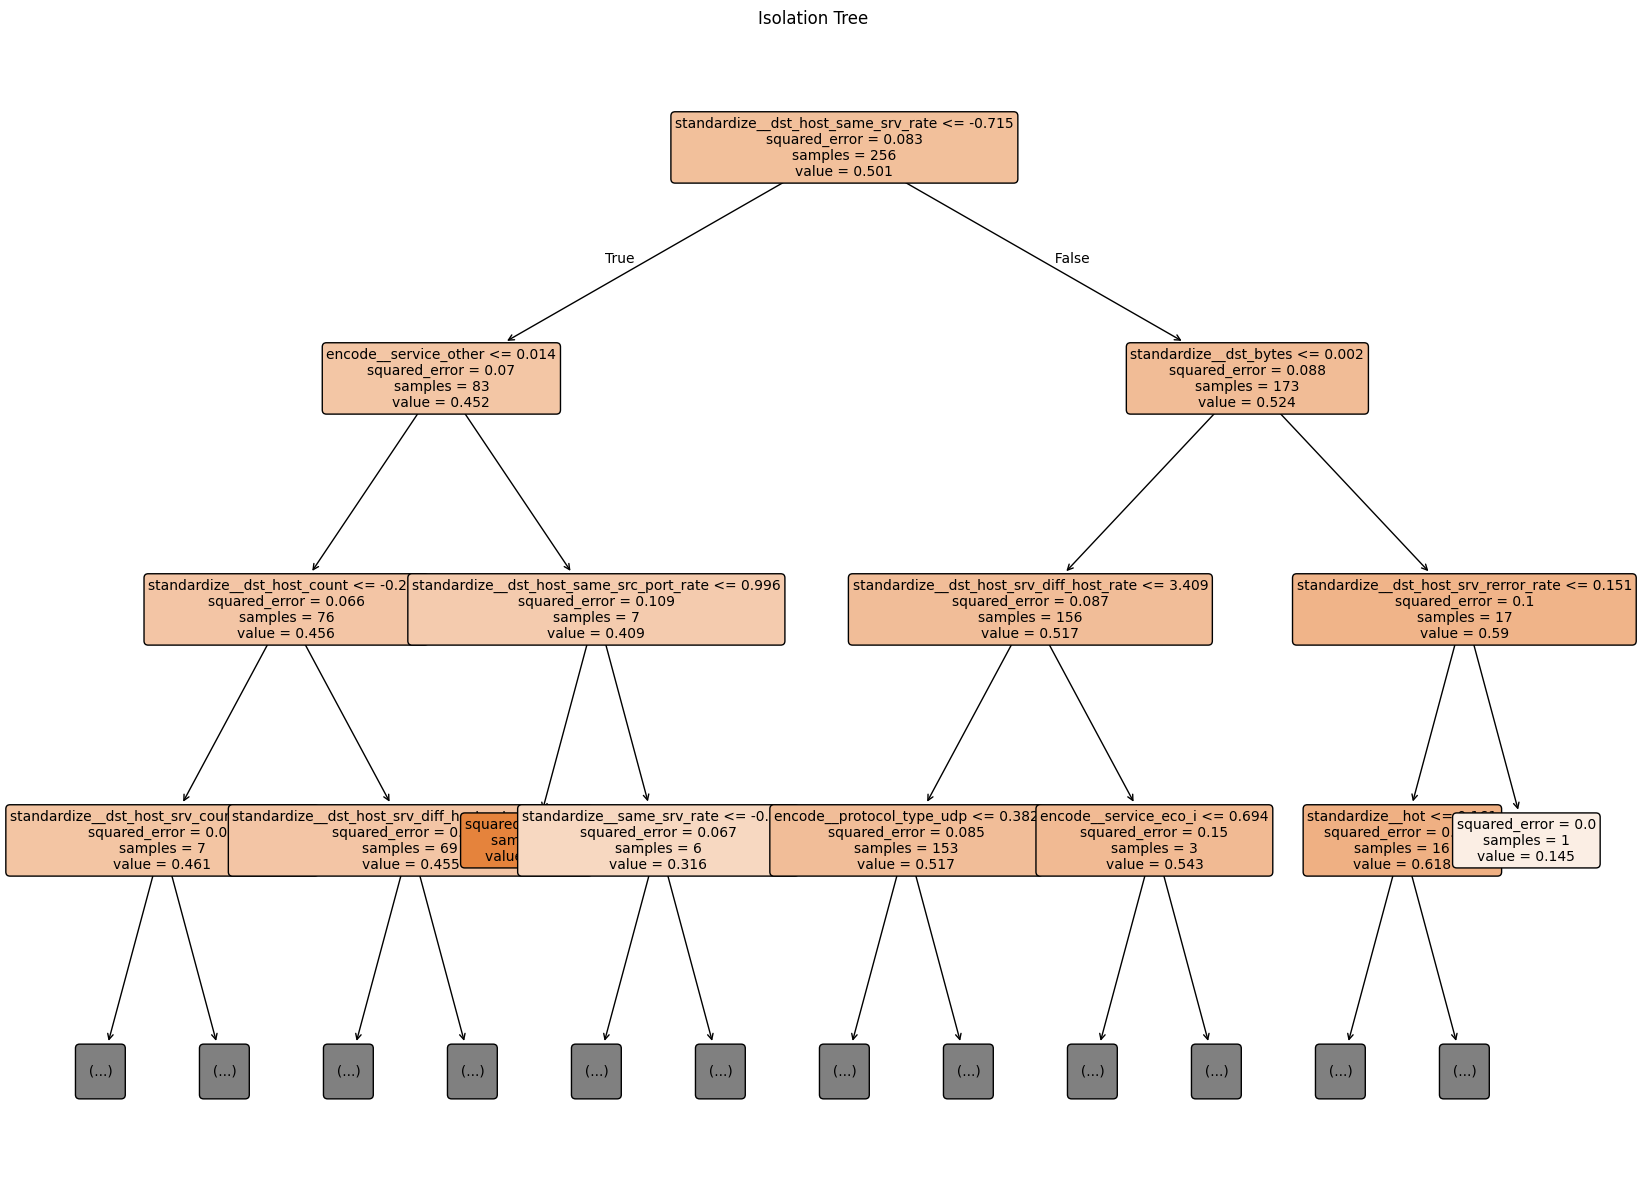

In [55]:
#Visualization
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random

# Pick a random tree from the forest, 200 possible trees

i = random.randint(0, optimal_num_trees - 1)
tree = model.estimators_[i]

# Plot the tree
plt.figure(figsize=(20, 15))
plot_tree(tree, 
          max_depth=3, 
          feature_names=X_sampled.columns,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Isolation Tree")
plt.show()

### Evaluation

In [57]:
#Evaluation, Visualization
import pandas as pd

#mandatory
#accuracy
#recall
#precision

Model_Data = [
    {"Model": "Decision Tree",
     "Accuracy": dt_accuracy,
     "Precision": dt_precision,
     "Recall": dt_recall},
    {"Model": "Random Forest",
     "Accuracy": rf_accuracy,
     "Precision": rf_precision,
     "Recall": rf_recall},
    {"Model": "KMeans",
     "Accuracy": kmeans_accuracy,
     "Precision": kmeans_precision,
     "Recall": kmeans_recall},
    {"Model": "Isolation Forest",
     "Accuracy": if_accuracy,
     "Precision": if_precision,
     "Recall": if_recall}
]

#optional
#F2
#False Negative Rate

df = pd.DataFrame(Model_Data[:], columns=Model_Data[0])
df.set_index("Model", inplace=True)
print(df)

                  Accuracy  Precision    Recall
Model                                          
Decision Tree     0.998502   0.996570  0.997292
Random Forest     0.999865   0.999809  0.999638
KMeans            0.691316   0.176023  0.072174
Isolation Forest  0.699496   0.358465  0.293958
